# Up-sampling with Transposed Convolution

When we use neural networks to generate images, it usually involves up-sampling from low resolution to high resolution.

There are various methods to conduct up-sample operation:

* Nearest neighbor interpolation
* Bi-linear interpolation
* Bi-cubic interpolation

All these methods involve some interpolation which we need to chose like a manual feature engineering that the network can not change later on.

Instead, we could use the transposed convolution which has learnable parameters [[1]](#ref1).

Examples of the transposed convolution usage:

* the generator in DCGAN takes randomly sampled values to produce a full-size image [[2]](#ref2).
* the semantic segmentation uses convolutional layers to extract features in the encoder and then restores the original image size in the encoder so that it can classify every pixel in the original image [[3]](#ref3).

The transposed convolution is also known as:

* Fractionally-strided convolution
* Deconvolution

But we will only use the word **transposed convolution** in this notebook.

One caution: the transposed convolution is the cause of the checkerboard artifacts in generated images [[4]](#ref4). The paper recommends an up-sampling followed by convolution to reduce such issues.  If the main objective is to generate images without such artifacts, it is worth considering one of the interpolation methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.layers import Conv2D
from keras.models import Sequential

%matplotlib inline

Using TensorFlow backend.


## Convolution Operation

### Input Matrix

We define a 4x4 matrix as the input.  We randomly generate values for this matrix using 1-5.

In [2]:
inputs = np.random.randint(1, 9, size=(4, 4))
inputs

array([[3, 3, 3, 6],
       [7, 4, 3, 2],
       [7, 2, 8, 5],
       [1, 7, 3, 1]])

The matrix is visualized as below.  The higher the intensity the bright the cell color is.

In [3]:
def show_matrix(m, color, cmap, title=None):
    rows, cols = len(m), len(m[0])
    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_yticks(list(range(rows)))
    ax.set_xticks(list(range(cols)))
    ax.xaxis.tick_top()  
    if title is not None:
        ax.set_title('{} {}'.format(title, m.shape), y=-0.5/rows)
    plt.imshow(m, cmap=cmap, vmin=0, vmax=1)
    for r in range(rows):
        for c in range(cols):
            text = '{:>3}'.format(int(m[r][c]))
            ax.text(c-0.2, r+0.15, text, color=color, fontsize=15)
    plt.show()
    
def show_inputs(m, title='Inputs'):
    show_matrix(m, 'b', plt.cm.Vega10, title)
    
def show_kernel(m, title='Kernel'):
    show_matrix(m, 'r', plt.cm.RdBu_r, title)
    
def show_output(m, title='Output'):
    show_matrix(m, 'g', plt.cm.GnBu, title)

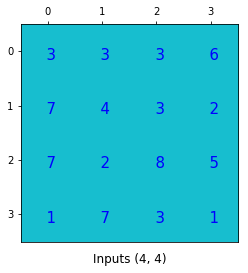

In [4]:
show_inputs(inputs)

We are using small values so that the display look simpler than with big values.  If we use 0-255 just like an gray scale image, it'd look like below.

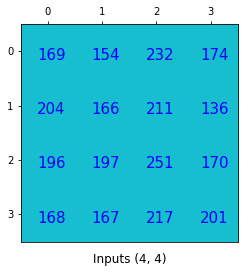

In [5]:
show_inputs(np.random.randint(100, 255, size=(4, 4)))

Apply a convolution operation on these values can produce big values that are hard to nicely display.

Also, we are ignoring the channel dimension usually used in image processing for a simplicity reason.

### Kernel

We use a 3x3 kernel (filter) in this example (again no channel dimension).

We only use 1-5 to make it easy to display the calculation results.

In [6]:
kernel = np.random.randint(1, 5, size=(3, 3))
kernel

array([[1, 2, 4],
       [1, 1, 3],
       [1, 2, 4]])

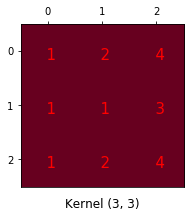

In [7]:
show_kernel(kernel)

### Convolution

With padding = 0 (padding='VALID') and strides = 1, the convolution produces a 2x2 matrix.

--- 

$H_m, W_m$: height and width of the input

$H_k, W_k$: height and width of the kernel

$P$: padding

$S$: strides

$H, W$: height and width of the output

$W = \frac{W_m - W_k + 2P}{S} + 1$

$H = \frac{H_m - H_k + 2P}{S} + 1$

---

With the 4x4 matrix and 3x3 kernel with no zero padding and stride of 1:

$\frac{4 - 3 + 2\cdot 0}{1} + 1 = 2$

So, with no zero padding and strides of 1, the convolution operation can be defined in a function like below:

In [8]:
def convolve(m, k):
    m_rows, m_cols = len(m), len(m[0]) # matrix rows, cols
    k_rows, k_cols = len(k), len(k[0]) # kernel rows, cols

    rows = m_rows - k_rows + 1 # result matrix rows
    cols = m_rows - k_rows + 1 # result matrix cols
    
    v = np.zeros((rows, cols), dtype=m.dtype) # result matrix
    
    for r in range(rows):
        for c in range(cols):
            v[r][c] = np.sum(m[r:r+k_rows, c:c+k_cols] * k) # sum of the element-wise multiplication
    return v

The result of the convolution operation is as follows:

In [9]:
output = convolve(inputs, kernel)
output

array([[84, 84],
       [87, 60]])

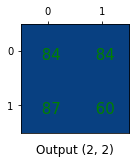

In [10]:
show_output(output)

One important point of such convolution operation is that it keeps the positional connectivity between the input values and the output values.

For example, `output[0][0]` is calculated from `inputs[0:3, 0:3]`.  The kernel is used to link between the two.

In [11]:
output[0][0]

84

In [12]:
inputs[0:3, 0:3]

array([[3, 3, 3],
       [7, 4, 3],
       [7, 2, 8]])

In [13]:
kernel

array([[1, 2, 4],
       [1, 1, 3],
       [1, 2, 4]])

In [14]:
np.sum(inputs[0:3, 0:3] * kernel) # sum of the element-wise multiplication

84

So, 9 values in the input matrix is used to produce 1 value in the output matrix.

### Going Backward

Now, suppose we want to go the other direction.  We want to associate 1 value in a matrix to 9 values to another matrix while keeping the same positional association.

For example, the value in the left top corner of the input is associated with the 3x3 values in the left top corner of the output.  

This is the core idea of the transposed convolution which we can use to up-sample a small image into a larger one while making sure the positional association (connectivity) is maintained.

Let's first define the convolution matrix and then talk about the transposed convolution matrix.

## Convolution Matrix

We can express a convolution operation using a matrix.  It is nothing but a kernel matrix rearranged so that we can use a matrix multiplication to conduct convolution operations.

In [15]:
def convolution_matrix(m, k):
    m_rows, m_cols = len(m), len(m[0]) # matrix rows, cols
    k_rows, k_cols = len(k), len(k[0]) # kernel rows, cols

    # output matrix rows and cols
    rows = m_rows - k_rows + 1 
    cols = m_rows - k_rows + 1
    
    # convolution matrix
    v = np.zeros((rows*cols, m_rows, m_cols)) 

    for r in range(rows):
        for c in range(cols):
            i = r * cols + c
            v[i][r:r+k_rows, c:c+k_cols] = k

    v = v.reshape((rows*cols), -1)
    return v, rows, cols

In [16]:
C, rows, cols = convolution_matrix(inputs, kernel)

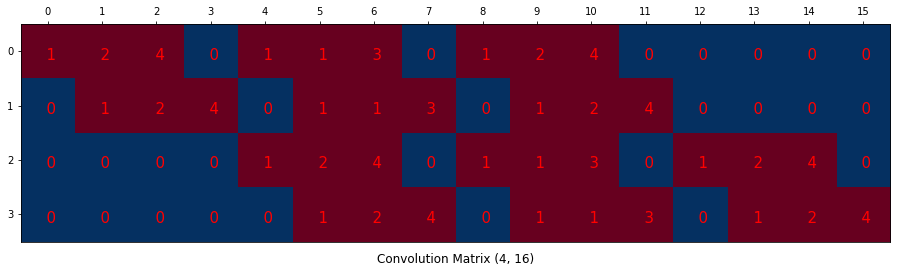

In [17]:
show_kernel(C, 'Convolution Matrix')

If we reshape the input into a column vector, we can use the matrix multiplication to perform convolution.

In [18]:
def column_vector(m):
    return m.flatten().reshape(-1, 1)

In [19]:
x = column_vector(inputs)
x

array([[3],
       [3],
       [3],
       [6],
       [7],
       [4],
       [3],
       [2],
       [7],
       [2],
       [8],
       [5],
       [1],
       [7],
       [3],
       [1]])

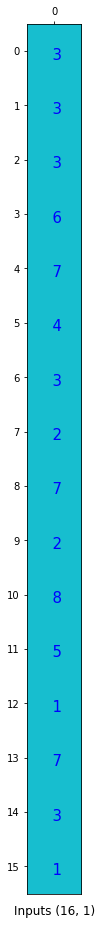

In [20]:
show_inputs(x)

In [21]:
output = C @ x
output

array([[ 84.],
       [ 84.],
       [ 87.],
       [ 60.]])

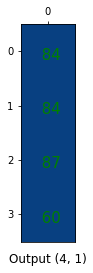

In [22]:
show_output(output)

We reshape it into the desired shape.

In [23]:
output = output.reshape(rows, cols)
output

array([[ 84.,  84.],
       [ 87.,  60.]])

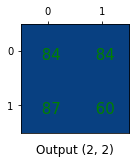

In [24]:
show_output(output)

This is exactly the same output as before.

## Transposed Convolution Matrix

Let's transpose the convolution matrix.

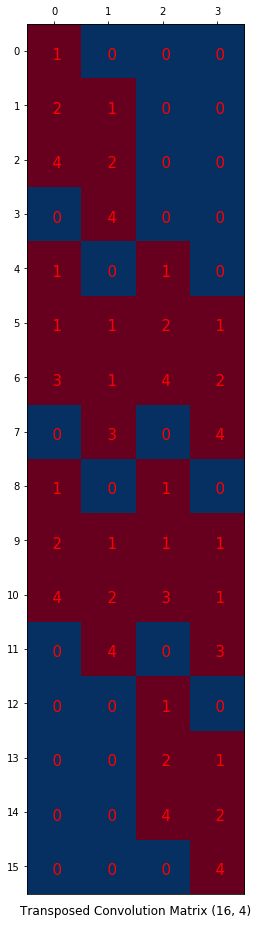

In [25]:
show_kernel(C.T, 'Transposed Convolution Matrix')

Let's make a new input whose shape is 4x1.

In [26]:
x2 = np.random.randint(1, 5, size=(4, 1))
x2

array([[2],
       [3],
       [4],
       [3]])

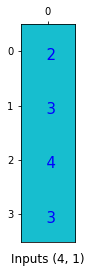

In [27]:
show_inputs(x2)

We matrix-multiply `C.T` with `x2` to up-sample `x2` from 4 (2x2) to 16 (4x4).  This operation has the same connectivity as the convolution but in the backward direction.  

As you can see, 1 value in the input `x2` is connected to 9 values in the output matrix via the transposed convolution matrix.

In [28]:
output2 = (C.T @ x2)
output2

array([[  2.],
       [  7.],
       [ 14.],
       [ 12.],
       [  6.],
       [ 16.],
       [ 31.],
       [ 21.],
       [  6.],
       [ 14.],
       [ 29.],
       [ 21.],
       [  4.],
       [ 11.],
       [ 22.],
       [ 12.]])

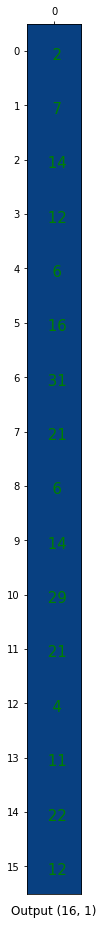

In [29]:
show_output(output2)

In [30]:
output2 = output2.reshape(4, 4)
output2

array([[  2.,   7.,  14.,  12.],
       [  6.,  16.,  31.,  21.],
       [  6.,  14.,  29.,  21.],
       [  4.,  11.,  22.,  12.]])

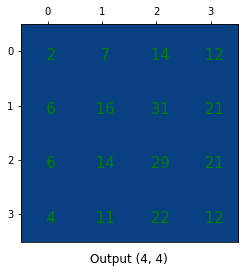

In [31]:
show_output(output2)

## Summary

As discussed at the beginning of this notebook the weights in the tranposed convolution matrix can be trained as part of a neural network back-propagation process.  As such, it eliminates the necessity for fixed up-sampling methods.

Note: we can emulate the transposed convolution using a direct convolution.  We first up-sample the input by adding zeros between the original values in a way that the direct convolution produces the same effect as the transposed convolution.  However, it is less efficient due to the need to add zeros to up-sample the input before the convolution.

## References

<a id="ref1"></a>
### [1] A guide to convolution arithmetic for deep learning

Vincent Dumoulin, Francesco Visin

https://arxiv.org/abs/1603.07285

<a id="ref2"></a>
### [2] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford, Luke Metz, Soumith Chintala

https://arxiv.org/pdf/1511.06434v2.pdf

<a id="ref3"></a>
### [3] Fully Convolutional Networks for Semantic Segmentation

Jonathan Long, Evan Shelhamer, Trevor Darrell

https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

<a id="ref4"></a>
### [4] Deconvolution and Checkerboard Artifacts

Augustus Odena, Vincent Dumoulin, Chris Olah
 
https://distill.pub/2016/deconv-checkerboard/
